In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import matplotlib as mpl
from pathlib import Path
plt.rcParams['lines.linewidth'] = 0.5
import matplotlib.style as mplstyle
mplstyle.use('fast')
from tqdm.autonotebook import tqdm
np.random.seed(123)

# OMpy-introduksjon

OMpy er en implementasjon av Oslometoden med ensembleestimering av usikkerhetene. Vi skal bare bry oss om første steg som da er unfolding.
Det er ganske mye "book keeping"-kode som er nødvendig for abstrahere arbeid med histogrammer og binning. De to viktigste klassene som gjør livet vårt enklere er `Vector` og `Matrix`, som er wrappere rundt numpy arrayer. 

For å definere en vektor må man gi både `N` array values og `N+1` bin edges. OMpy støtter left edged bins (hver edge definerer venstre kant i binnet, +1 som definerer siste høyre kant), mid edged bins (hver edge definerer midtpunktet i binnet, +1 som definerer første venstre kant), uniform bins (alle bins er av samme størrelse) og non uniform bins (ingen restriksjoner på bin-størrelse). Hvis man definerer en vektor som er uniform, er det tilstrekkelig å gi `N` bin edges da OMpy kan finne den den gjenværende frihetsgraden. Left uniform bins er default.

In [5]:
edges = np.linspace(0, 100, 10)
y = 2*edges**2 + 0.6
vector = om.Vector(X=edges, values=y)
print(vector)

Index left uniform with 10 bins [keV] : X₀ = 0.00, ΔX = 11.11, Xₙ = 111.11
Label: Energy
Value alias: 
ylabel: Counts
Total counts: 7.04e+04

Values:
[6.00000000e-01 2.47513580e+02 9.88254321e+02 2.22282222e+03
 3.95121728e+03 6.17343951e+03 8.88948889e+03 1.20993654e+04
 1.58030691e+04 2.00006000e+04]


Binsene og arrayet har ofte fysikalske tolkninger. For å gjøre kode mer leselig kan man aliase disse ved å spesifisere argumentnavnet når man konstruerer vektorene. Første keyword er alltid bins, andre keyword er alltid array. De defaulte attributnavnene `X` og `values` er alltid tilgjenglig. Hvis bins er energi og array er counts, kan man da skrive:

In [11]:
vector = om.Vector(E=edges, counts=y)
print(vector)
print("\nEnergy:\n", vector.E)
print("\nCounts:\n", vector.counts)

Index left uniform with 10 bins [keV] : X₀ = 0.00, ΔX = 11.11, Xₙ = 111.11
Label: Energy
Alias: E
Value alias: counts
ylabel: Counts
Total counts: 7.04e+04

Values:
[6.00000000e-01 2.47513580e+02 9.88254321e+02 2.22282222e+03
 3.95121728e+03 6.17343951e+03 8.88948889e+03 1.20993654e+04
 1.58030691e+04 2.00006000e+04]

Energy:
 [  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]

Counts:
 [6.00000000e-01 2.47513580e+02 9.88254321e+02 2.22282222e+03
 3.95121728e+03 6.17343951e+03 8.88948889e+03 1.20993654e+04
 1.58030691e+04 2.00006000e+04]


Indeksering er støttet på fire måter:
- Er vanlig `vector[]`-indeksering fungerer som i numpy og sender tilbake er numpy array.
- `vector.iloc[]` fungerer som numpy-indeksering, men sender tilbake et ompy array.
- `vector.vloc[]` gjør en konversjon fra bins til integers og gir tilbake et ompy array.
- `vector.loc[]` fungerer som en kombinasjon av `iloc` og `vloc`, der `int` tolkes som en vanlig `int` mens alle andre verdier tolkes som i `vloc`.

In [31]:
print(f"{vector[5]=}")
print(f"{vector.iloc[5]=}")
print(f"{edges[5]=}")
print(f"{vector.vloc[55.6]=}")
print(f"{vector.loc[55.6]=}")
print(f"{vector.loc[5]=}")
print()
print(f"{vector[5:]=}")
print(f"{vector.iloc[5:]=}")
print(f"{edges[5:]=}")
print(f"{vector.vloc[55.6:]=}")
print(f"{vector.loc[55.6:]=}")
print(f"{vector.loc[5:]=}")

vector[5]=6173.43950617284
vector.iloc[5]=6173.43950617284
edges[5]=55.55555555555556
vector.vloc[55.6]=6173.43950617284
vector.loc[55.6]=6173.43950617284
vector.loc[5]=6173.43950617284

vector[5:]=array([ 6173.43950617,  8889.48888889, 12099.3654321 , 15803.0691358 ,
       20000.6       ])
vector.iloc[5:]=<ompy.array.vector.Vector object at 0x7f8bfa14b0a0>
edges[5:]=array([ 55.55555556,  66.66666667,  77.77777778,  88.88888889,
       100.        ])
vector.vloc[55.6:]=<ompy.array.vector.Vector object at 0x7f8bfa123100>
vector.loc[55.6:]=<ompy.array.vector.Vector object at 0x7f8bfa120790>
vector.loc[5:]=<ompy.array.vector.Vector object at 0x7f8bfa08b2b0>


Enheter i OMpy er støttet gjennom `Pint`-pakken. Av konvensjon defaulter bins i vektorer og matriser til `keV`. Indeksering og funksjonskall støtter enheter:

In [42]:
print(f"{vector.loc['78keV']=}")
print(f"{vector.loc['5.5e-2MeV']=}")

vector.loc['78keV']=12099.365432098764
vector.loc['5.5e-2MeV']=3951.217283950617


Dette lar oss enkelt subsette vektorer, for eksempel hvis vi vil ha alle verdier etter 3. indeks og opp til men ikke inkludert binnet som inneholdet 78keV:

In [44]:
vec = vector.loc[3:'<78keV']
print(vec)

Index left uniform with 3 bins [keV] : X₀ = 33.33, ΔX = 11.11, Xₙ = 66.67
Label: Energy
Alias: E
Value alias: counts
ylabel: Counts
Total counts: 1.23e+04

Values:
[2222.82222222 3951.21728395 6173.43950617]


Aritmetiske operasjoner fungerer akkurat som med numpy array, bare med en sjekk om at bins'ene er kompatible. Merk at av en numpy-serværdighet vil alle right associated operations gi tilbake numpy arrayer istedet for ompy arrayer.

In [47]:
vec = 2*vector**3.2

Plotting er enkelt med `vector.plot()`. Den `Axes` som lages eller brukes sendes alltid tilbake som første verdi.

<IPython.core.display.Javascript object>


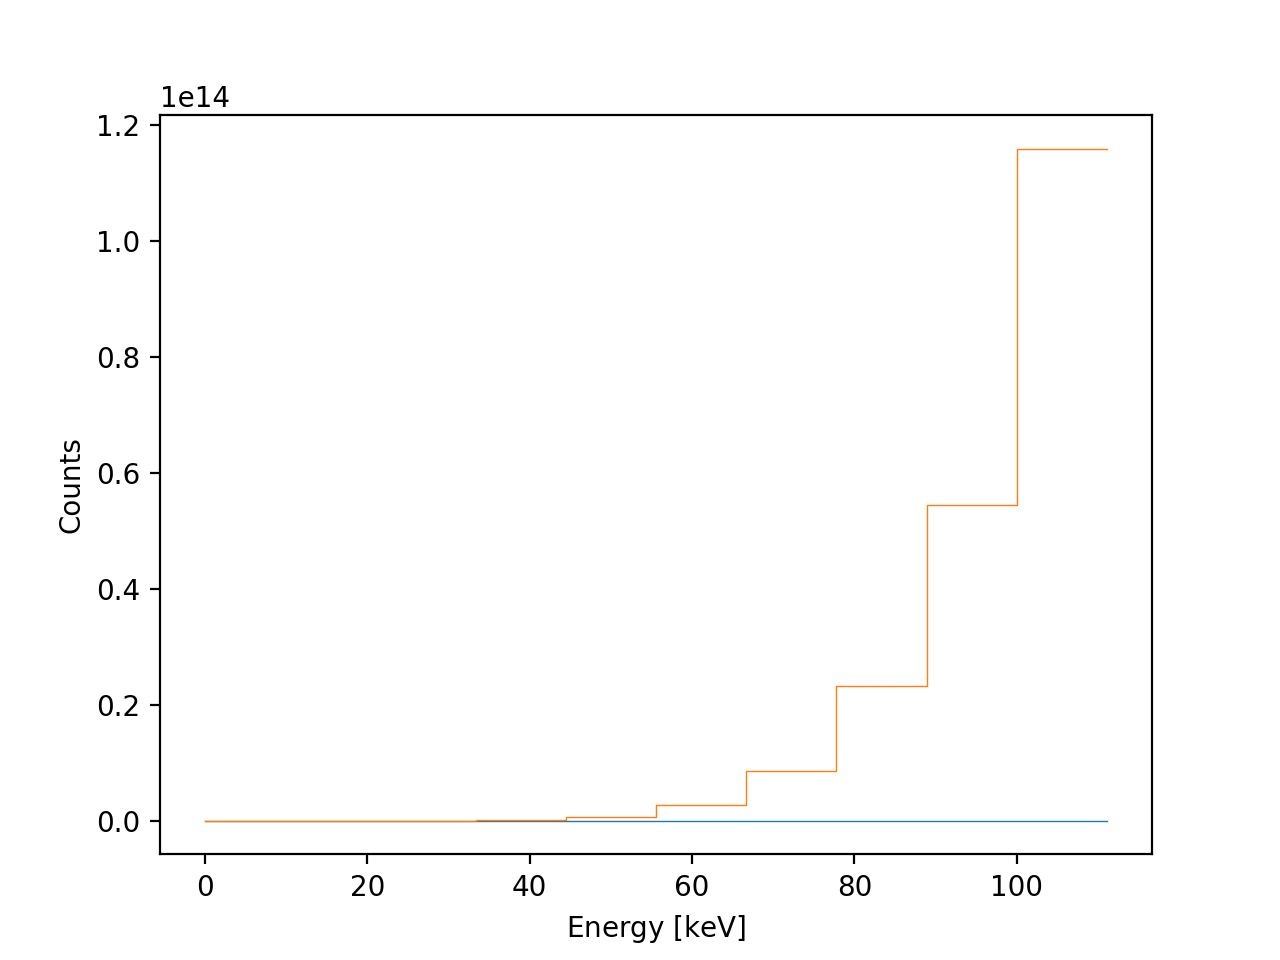

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]', ylabel='Counts'>

In [50]:
ax = vector.plot(label='vector')
vec.plot(ax=ax, label='vec')

Lagring og lesing til/fra fil gjøres med `.save()` og `Vector.from_path()`. Default er numpy sitt `npz`-format, men andre er tilgjenglig dog med tap av metadata.

Matriser fungerer helt likt som vektorer, med snublepunktet om at matrisene plottes transponert av hvordan de defineres.

<IPython.core.display.Javascript object>


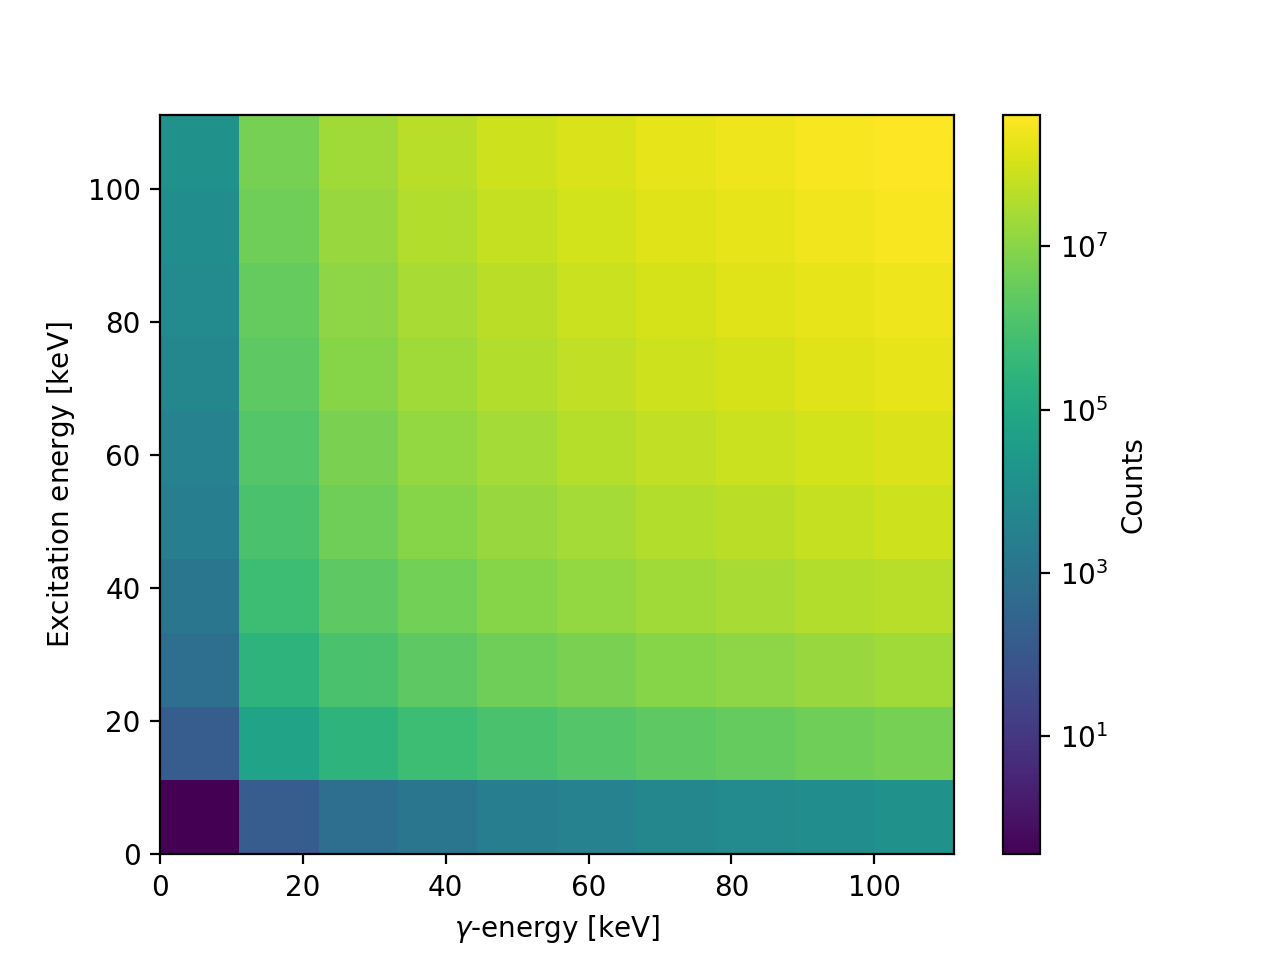

(<AxesSubplot: xlabel='$\\gamma$-energy [$\\mathrm{keV}$]', ylabel='Excitation energy [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f8c8a6a6bf0>,
  <matplotlib.colorbar.Colorbar at 0x7f8c8a644c40>))

In [51]:
matrix = om.Matrix(X=edges, Y=edges, values=np.outer(y, y))
matrix.plot()

<IPython.core.display.Javascript object>


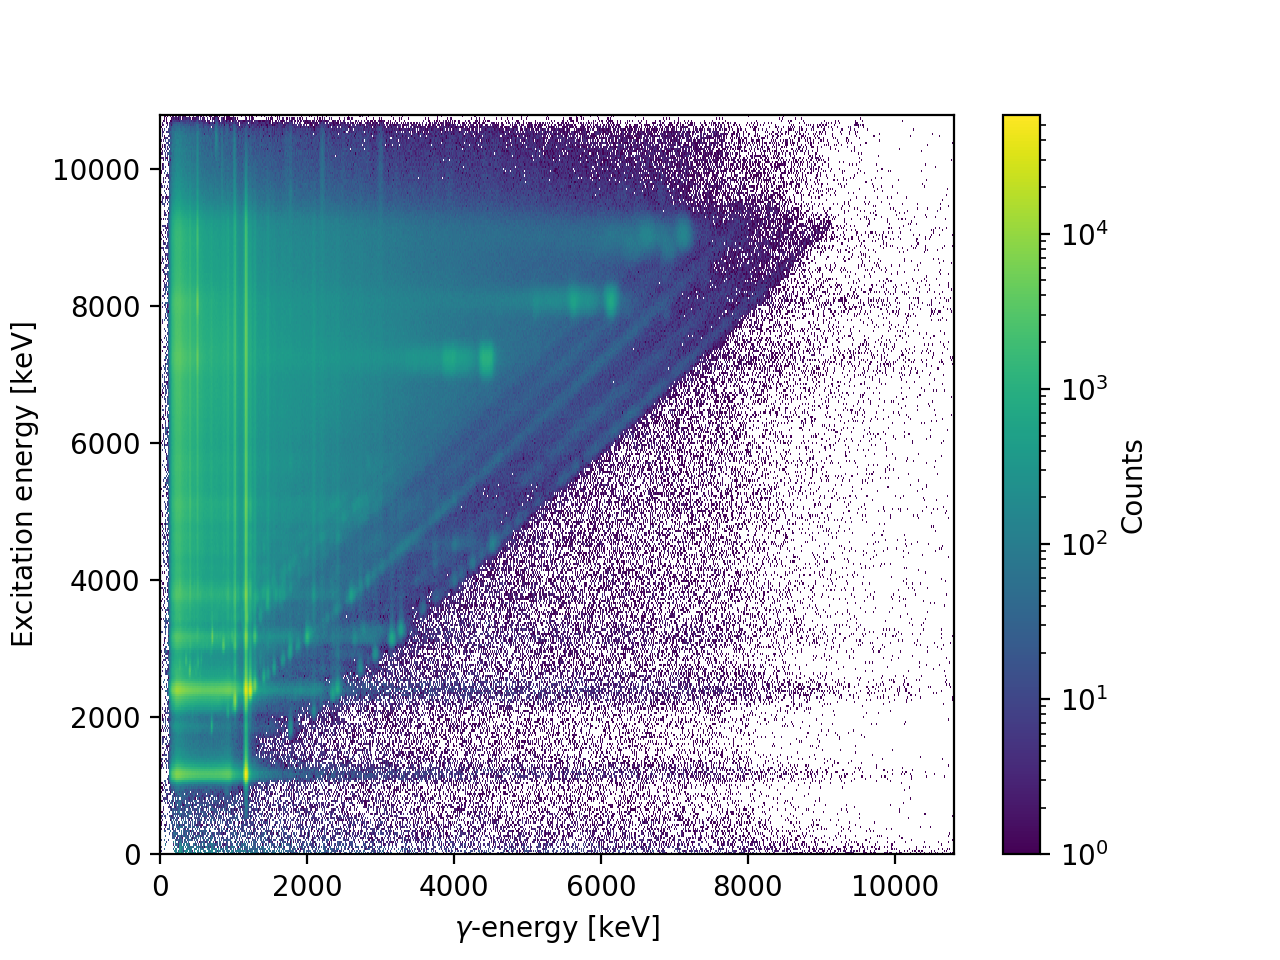

(<AxesSubplot: xlabel='$\\gamma$-energy [$\\mathrm{keV}$]', ylabel='Excitation energy [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f8c28434280>,
  <matplotlib.colorbar.Colorbar at 0x7f8c285a6530>))

In [70]:
# Last inn 120Sn fra fil
tinn = om.Matrix.from_path("120Sn.npz")
tinn.plot()

<IPython.core.display.Javascript object>


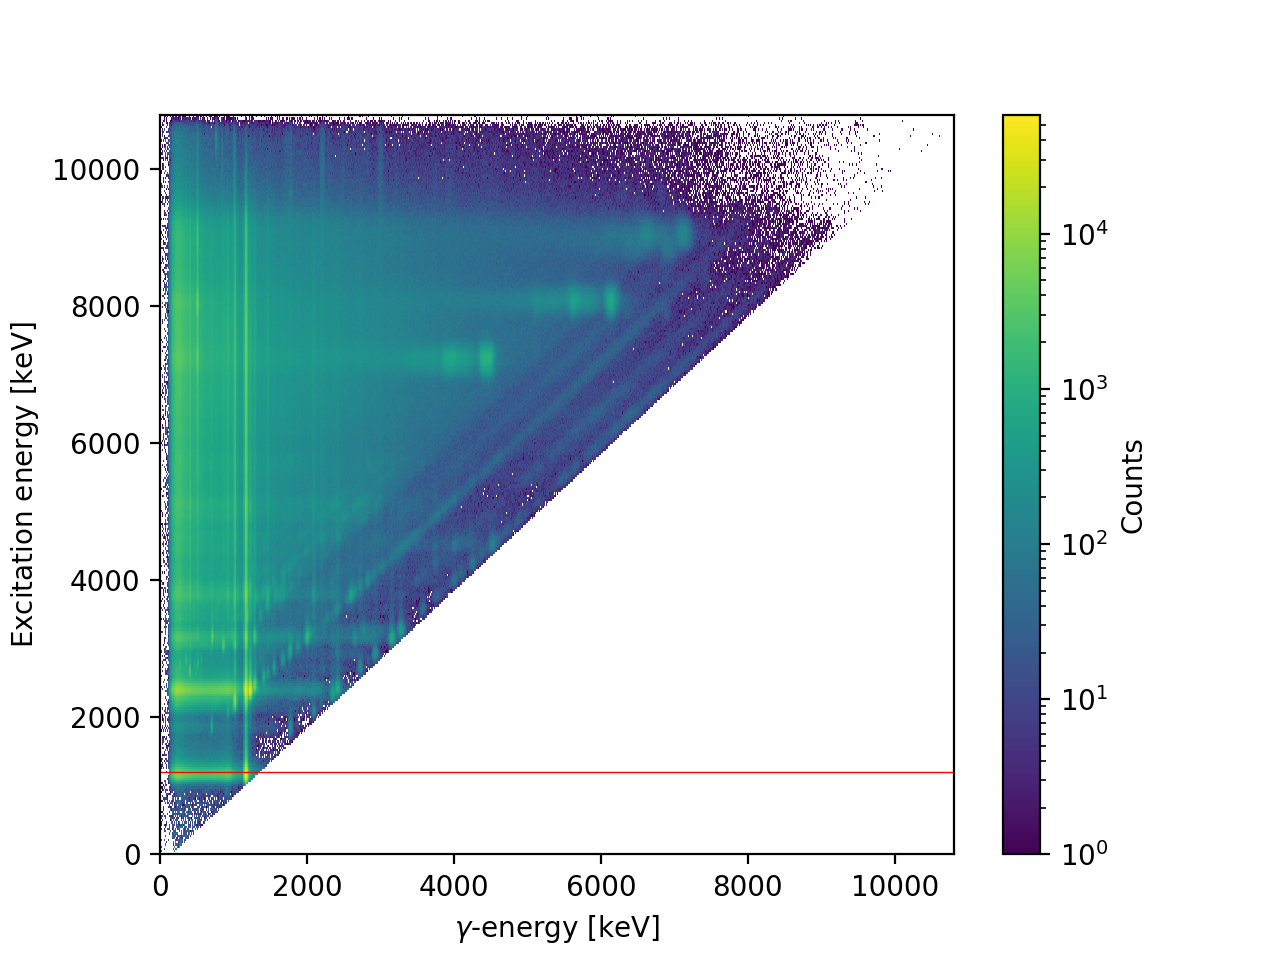

<IPython.core.display.Javascript object>


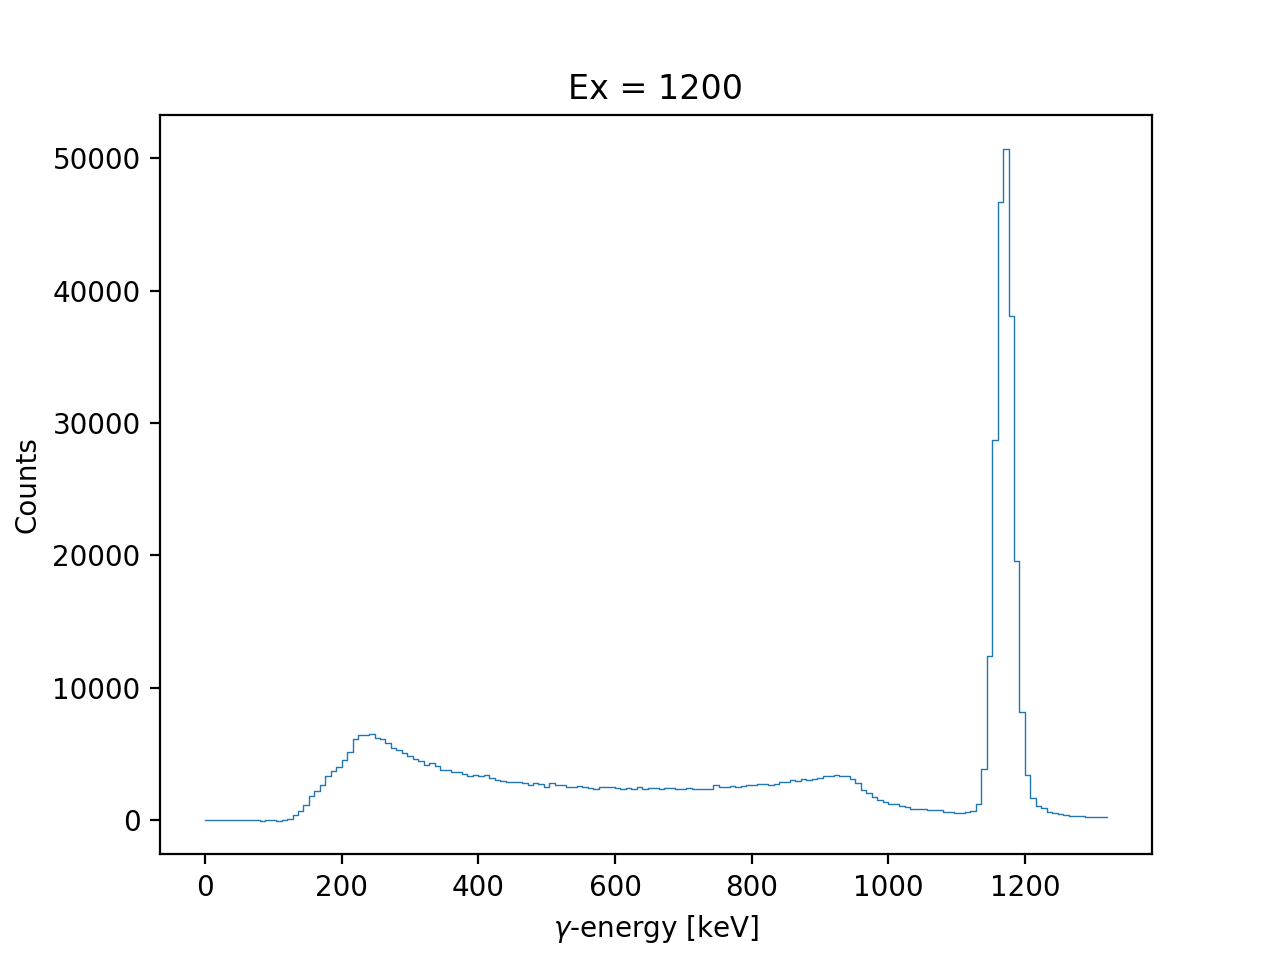

Text(0.5, 1.0, 'Ex = 1200')

In [79]:
# Vi liker ikke støyen som kommer på høyreside av diagonalen, så vi kutter dem vekk
# Dette bør strengt tatt gjøres ved å bruke detektoroppløsning, men den delen er ikke ferdig kodet,
# så her gjør vi det manuelt.
line = om.Line(p1=(700,0), slope=1)
tinn[line.below(tinn)] = 0
# Vi henter ut et spektrum til å jobbe med
Ex = 1200          # Ex    Eg
spectrum = tinn.vloc[Ex, :1.1*Ex] # Merk av vi også kutter Eg ved Eg=Ex + 10%
ax, _ = tinn.plot()
ax.axhline(Ex, color='r')
ax = spectrum.plot()
ax.set_title(f'Ex = {Ex}')

Responsen er et herk å lage, men med moderne teknologi er den bare noen tastetrykk unna!
Her bruker vi responsen for Oscar laget i 2020.

In [81]:
# Hent fra database
resp = om.Response.from_db('oscar2020')
# Kjør denne hvis du blir bedt om det.
#resp.interpolate_compton()
# Responsen må skreddersyes til vektoren/matrisen som skal unfoldes.
R_delta = resp.specialize_like(spectrum)

ValueError: Requested energy grid is too low. The lowest energy in the response is 58.50 keV. The requested energy grid starts at 0.00 keV. The energy grid must be truncated at index 8.

Nei, å nei, dette likte ikke OMpy. Responsen vår er begrenset av hvor lavt simuleringene går. 
Feilmeldingen informer oss om at responsen stopper ved `58.5` keV og at vi må kutte vårt spektrum ved indeks 8.

In [82]:
spectrum = spectrum.iloc[8:]  # Kjør meg ikke mer enn én gang!

<IPython.core.display.Javascript object>


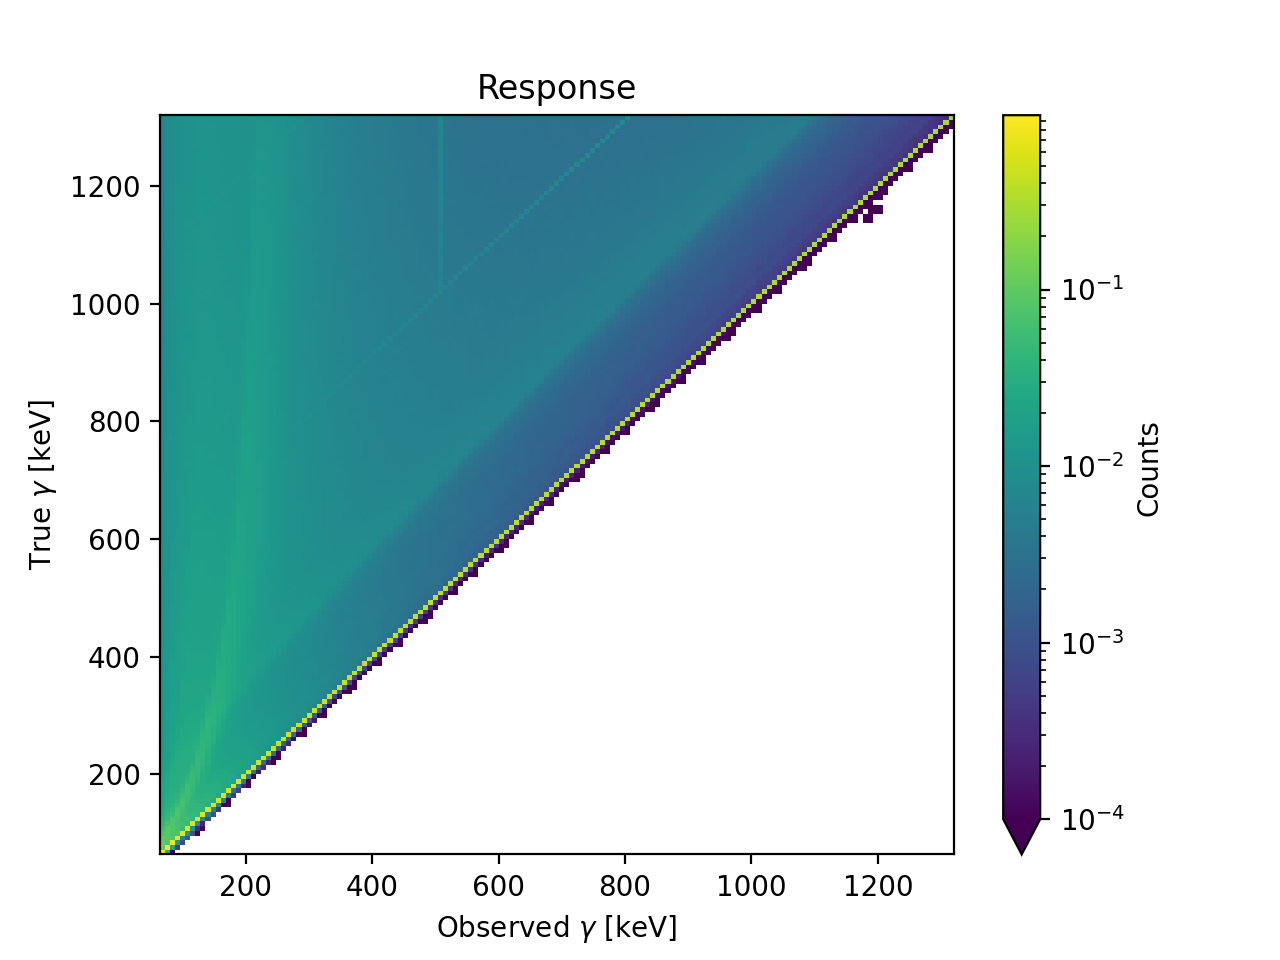

<IPython.core.display.Javascript object>


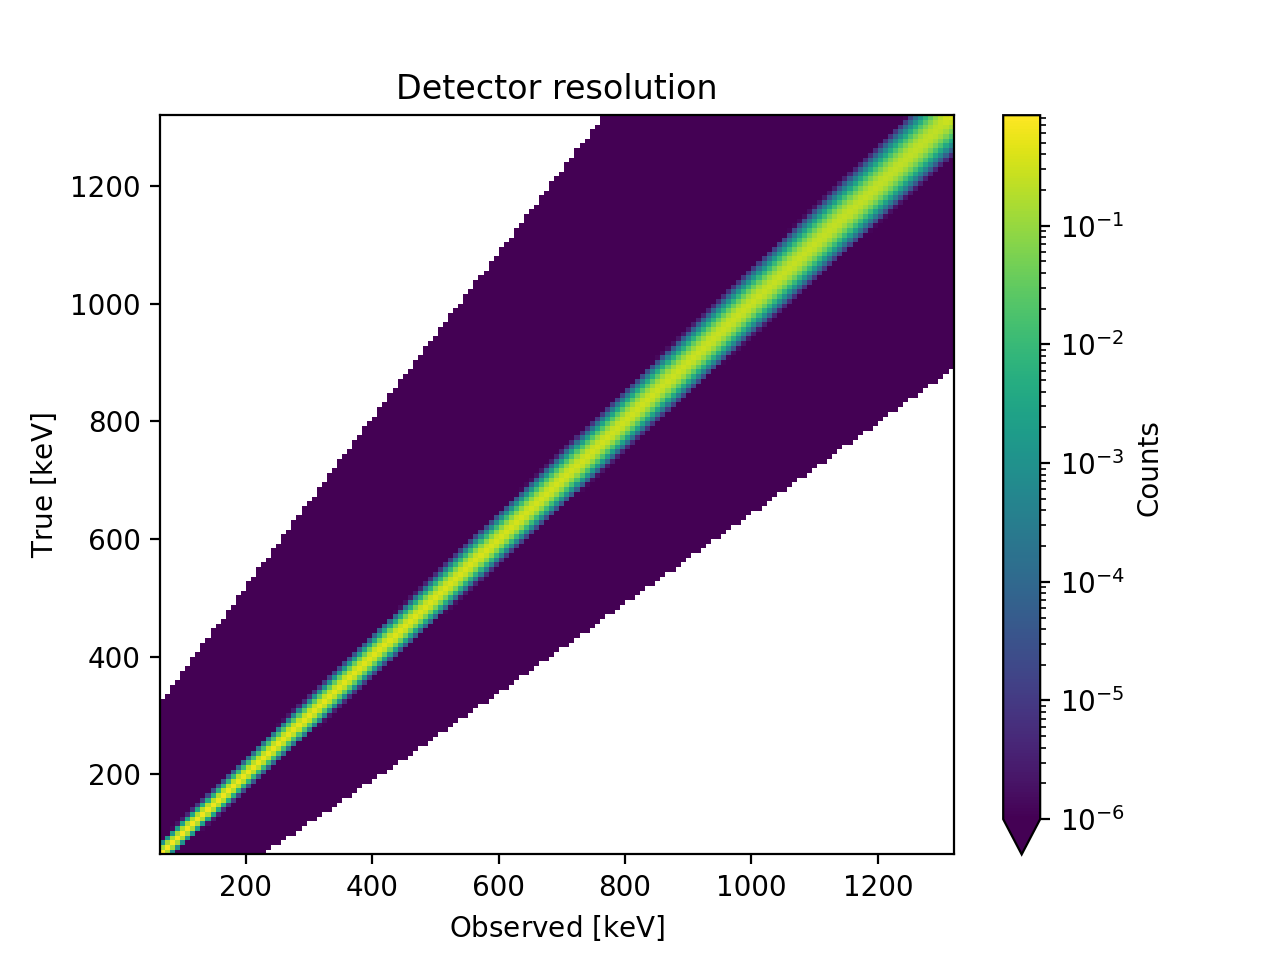

(<AxesSubplot: title={'center': 'Detector resolution'}, xlabel='Observed [$\\mathrm{keV}$]', ylabel='True [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f8c274ad4e0>,
  <matplotlib.colorbar.Colorbar at 0x7f8c27492da0>))

In [93]:
# Andre forsøk
R_delta = resp.specialize_like(spectrum)
G = resp.gaussian_like(spectrum)
R_delta.plot(scale='log', vmin=1e-4)
G.plot(scale='log')

Matrisen `R_delta` går fra `$\mu$` til folded rom uten detektorutsmøring. `G` er detektorutsmøringen.
Den "vanlige" responsen er `GR_delta`, som vi lager med et matriseprodukt. Litt forvirrende siden OMpy har transponert matrisene per konvensjon, så vi må transponere dem tilbake.

<IPython.core.display.Javascript object>


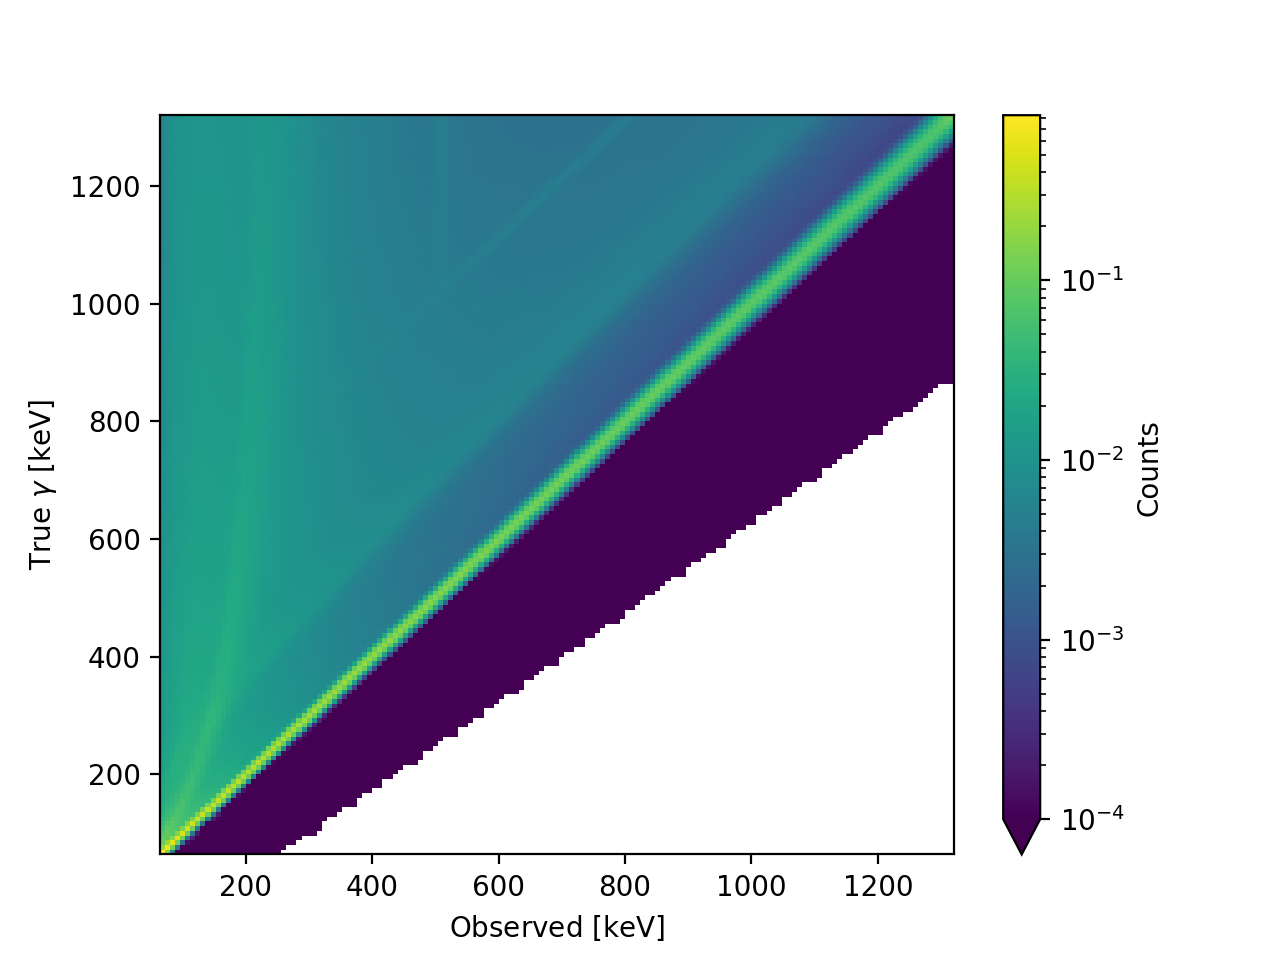

(<AxesSubplot: xlabel='Observed [$\\mathrm{keV}$]', ylabel='True $\\gamma$ [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7f8be93b5300>,
  <matplotlib.colorbar.Colorbar at 0x7f8be97b7d90>))

In [92]:
GR = G.T@R_delta.T
GR.T.plot(scale='log', vmin=1e-4)

# Enkeltopp

In [101]:
mu = om.linspace(60, 5000, 100)
# We place a delta peak at 4500keV with 5000 counts
mu.vloc[4500.0] = 5000
# Create the response
resp = om.Response.from_db('oscar2020')
R = resp.specialize_like(mu)
G = resp.gaussian_like(mu)
GR = G.T@R.T
# Fold the delta peak.
nu = GR@mu
# Poisson sample. The function umap runs the function over the first ompy array and wraps it back into the array
n = om.umap(nu, np.random.poisson)

<IPython.core.display.Javascript object>


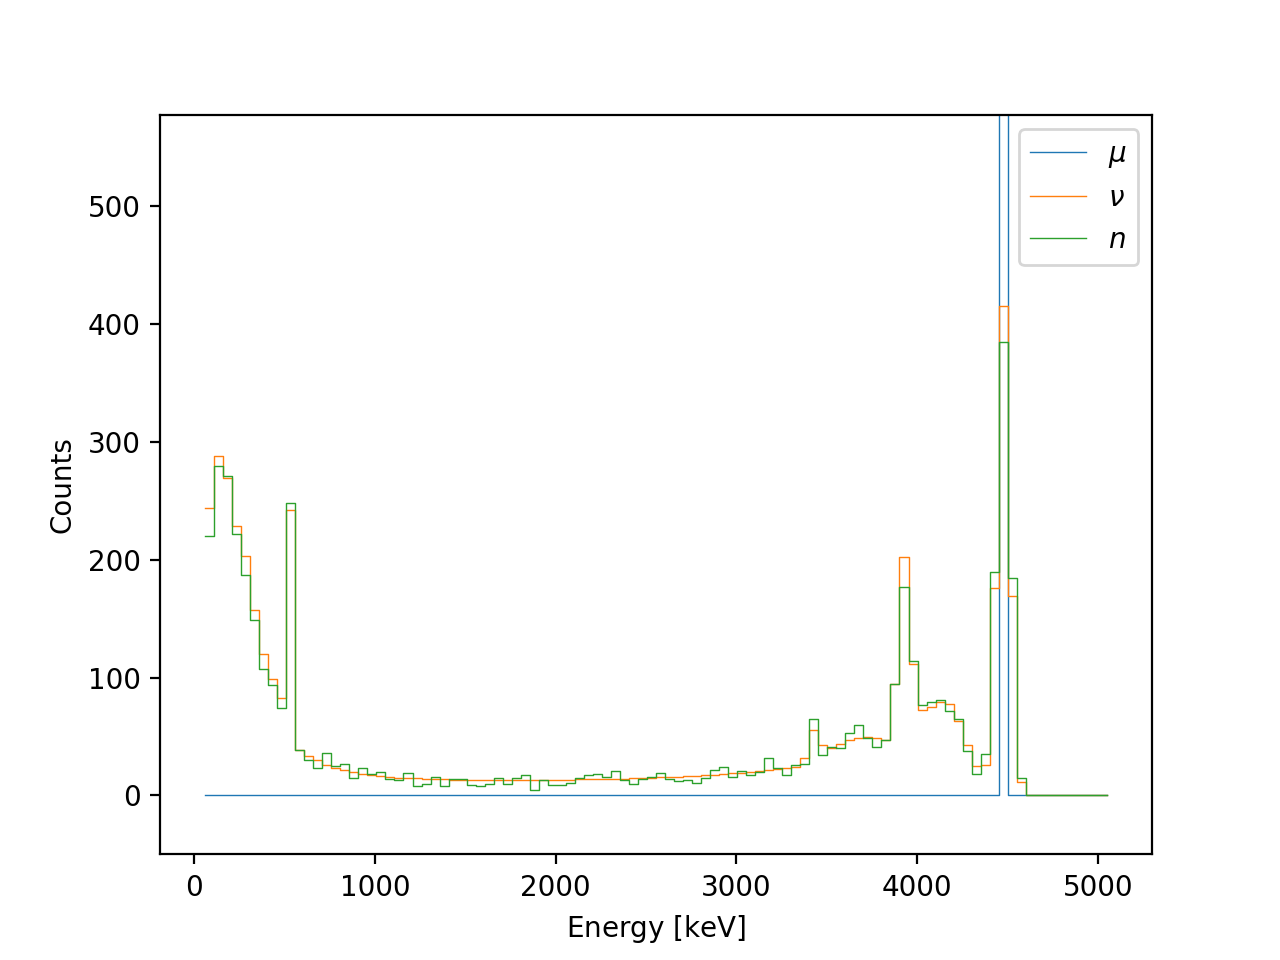

(-50.0, 577.5)

In [107]:
ax = mu.plot(label=r'$\mu$')
nu.plot(ax=ax, label=r'$\nu$')
n.plot(ax=ax, label=r'$n$')
ax.legend()
ax.set_ylim(-50, 1.5*max(n))

# Flertopp

# "Kontinuerlige" data

Er ikke åpenbart hvordan vi lager realistiske (kvasi)-kontinuerlige data. Jeg jukser dem til ved å ta eksperimentelle data som $\mu$ og redusere compton-biten.

<IPython.core.display.Javascript object>


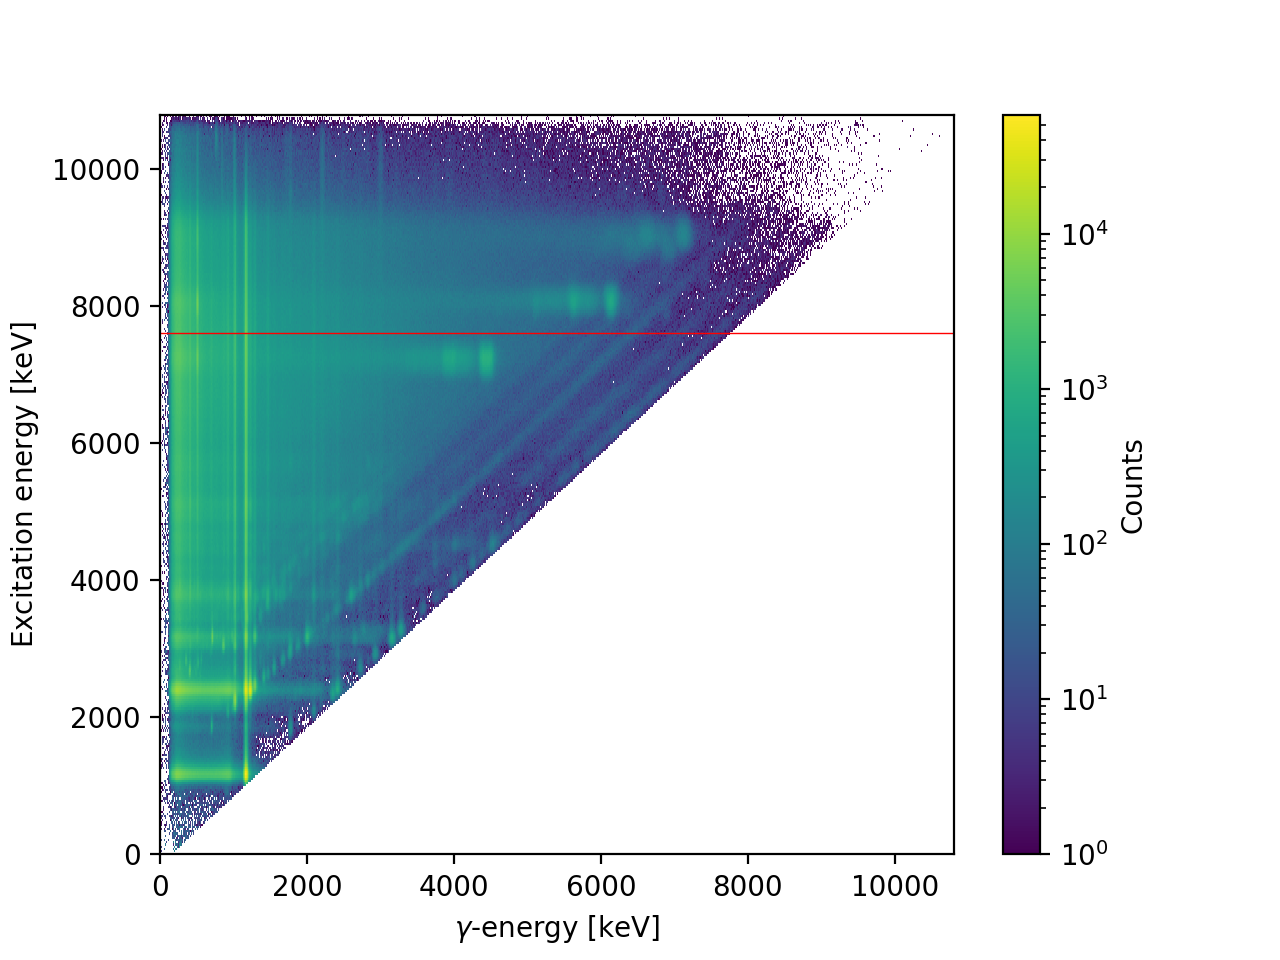

<IPython.core.display.Javascript object>


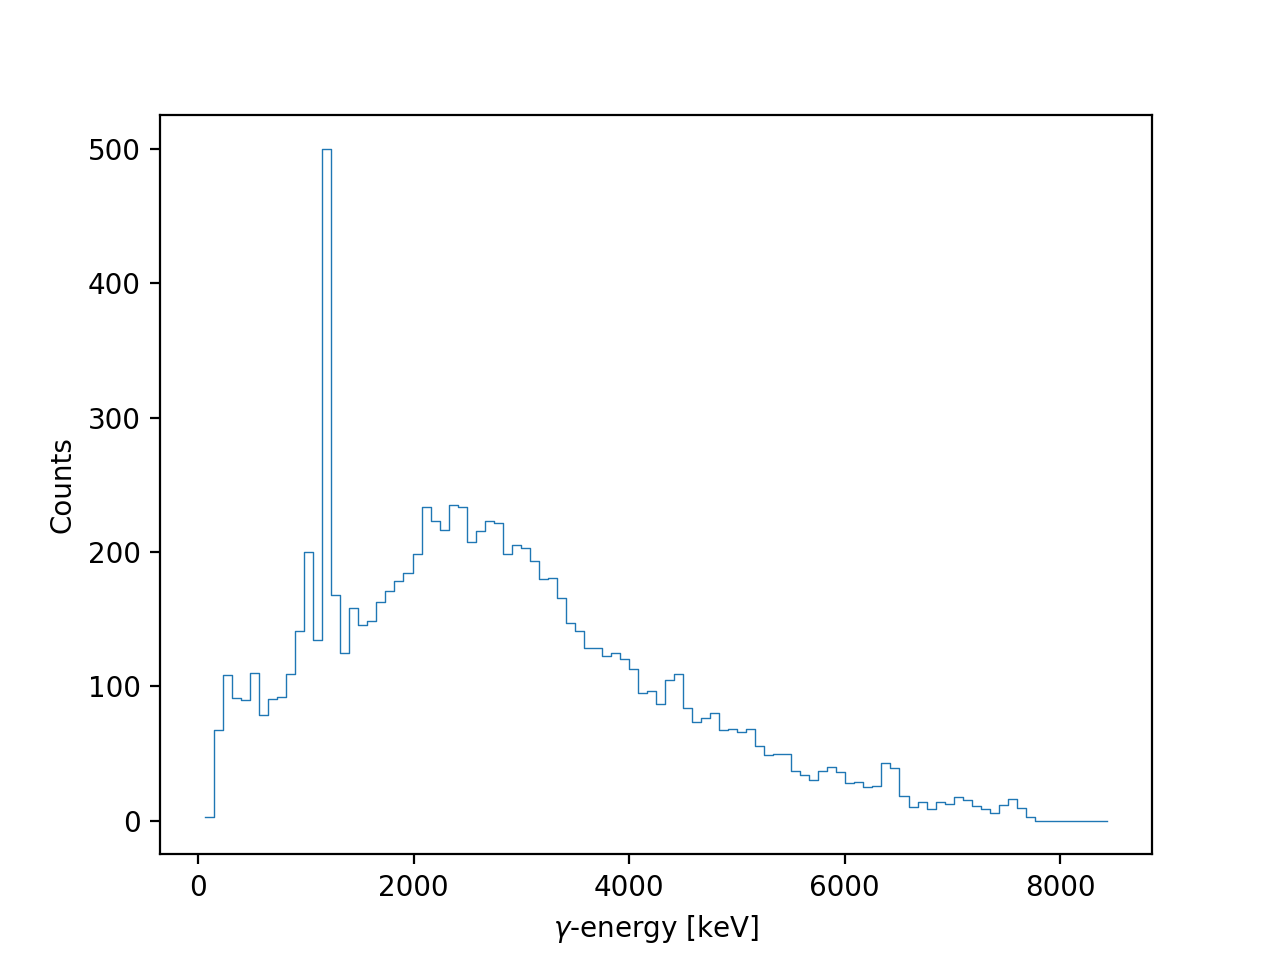

In [117]:
tinn = om.Matrix.from_path("120Sn.npz")
line = om.Line(p1=(700,0), slope=1)
tinn[line.below(tinn)] = 0
Ex = 7600.0
v = tinn.vloc[Ex, '>60.0':1.1*Ex]
ax, _ = tinn.plot()
ax.axhline(Ex, color='r')

# Create a logistic curve
x = v.X
loglerp = 1/(1+np.exp(-1/500 * (x-2000)))
w = v * loglerp
mu = w.rebin(numbins=100)
# Reduce number of counts
mu *= 500 / max(mu)

ax = mu.plot()

In [118]:
resp = om.Response.from_db('oscar2020')
R = resp.specialize_like(mu)
G = resp.gaussian_like(mu)
GR = G.T@R.T
nu = GR@mu
n = om.umap(nu, np.random.poisson)

<IPython.core.display.Javascript object>


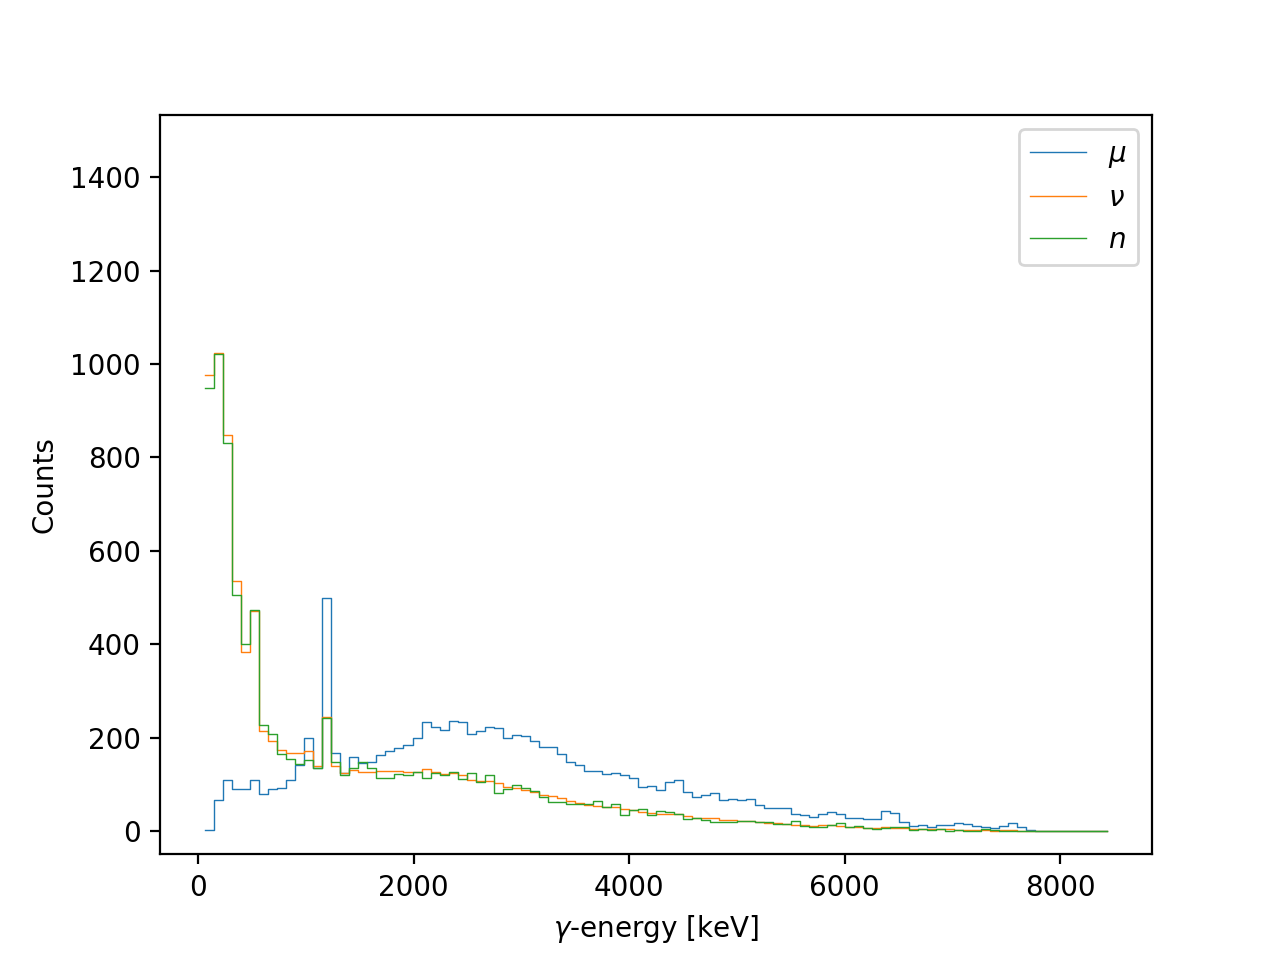

(-50.0, 1533.0)

In [119]:
ax = mu.plot(label=r'$\mu$')
nu.plot(ax=ax, label=r'$\nu$')
n.plot(ax=ax, label=r'$n$')
ax.legend()
ax.set_ylim(-50, 1.5*max(n))